In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
from tensorflow import keras

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [3]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

# New Train

In [4]:
pep = tf.keras.layers.Input(shape=((30,)))
input1_ = tf.keras.layers.Embedding(21, 32, input_length=30, mask_zero=True)(pep)
input1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input1_)

In [5]:
pep = tf.keras.layers.Input(shape=((30,)))
input1_ = tf.keras.layers.Embedding(23, 50, input_length=30, mask_zero=True)(pep)
input1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input1_)

reshap = keras.backend.reshape(input1, [-1, 30, 50, 1])

cnn1 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Conv1D(
        filters=32, kernel_size=3, strides=1, padding='same')
    )(reshap)

avgpool = tf.keras.layers.TimeDistributed(
    tf.keras.layers.AveragePooling1D(pool_size=2)
    )(cnn1)

flat = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Flatten()
    )(avgpool)

lstm = tf.keras.layers.LSTM(64)(flat)
    
den = tf.keras.layers.Dense(64, activation='relu')(lstm)
dropout1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(den)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout1)

model = tf.keras.Model(inputs=pep, outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 50)            1150      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
tf.reshape (TFOpLambda)      (None, 30, 50, 1)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 50, 32)        128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 25, 32)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 800)           0     

In [6]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

# 1. Make Data X_train, y_train, X_test, y_test

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [8]:
# make DeepMSpeptide format
args = file_path + 'detect_peptide_train_noptm_largedata.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y_noptm_largedata.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm_largedata.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y_noptm_largedata.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)


Loading input peptides
Succesfully loaded 641892 peptides and skipped 0
Loading input peptides
Succesfully loaded 129204 peptides and skipped 0
(513513, 30) (128379, 30) (129204, 30) (513513,) (128379,) (129204,)


# 2. train

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [10]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val),
                                       callbacks=[es])

Epoch 1/200
5136/5136 [==============================] - 80s 14ms/step - loss: 0.5532 - accuracy: 0.7069 - val_loss: 0.4690 - val_accuracy: 0.7756
Epoch 2/200
5136/5136 [==============================] - 74s 14ms/step - loss: 0.4707 - accuracy: 0.7755 - val_loss: 0.4492 - val_accuracy: 0.7874
Epoch 3/200
5136/5136 [==============================] - 72s 14ms/step - loss: 0.4524 - accuracy: 0.7878 - val_loss: 0.4433 - val_accuracy: 0.7923
Epoch 4/200
5136/5136 [==============================] - 72s 14ms/step - loss: 0.4416 - accuracy: 0.7941 - val_loss: 0.4287 - val_accuracy: 0.8030
Epoch 5/200
5136/5136 [==============================] - 74s 14ms/step - loss: 0.4343 - accuracy: 0.7988 - val_loss: 0.4241 - val_accuracy: 0.8065
Epoch 6/200
5136/5136 [==============================] - 72s 14ms/step - loss: 0.4263 - accuracy: 0.8053 - val_loss: 0.4181 - val_accuracy: 0.8099
Epoch 7/200
5136/5136 [==============================] - 68s 13ms/step - loss: 0.4213 - accuracy: 0.8078 - val_loss: 0

5136/5136 [==============================] - 126s 24ms/step - loss: 0.3785 - accuracy: 0.8308 - val_loss: 0.3841 - val_accuracy: 0.8273
Epoch 57/200
5136/5136 [==============================] - 123s 24ms/step - loss: 0.3776 - accuracy: 0.8310 - val_loss: 0.3831 - val_accuracy: 0.8285
Epoch 58/200
5136/5136 [==============================] - 125s 24ms/step - loss: 0.3790 - accuracy: 0.8300 - val_loss: 0.3844 - val_accuracy: 0.8273
Epoch 59/200
5136/5136 [==============================] - 124s 24ms/step - loss: 0.3756 - accuracy: 0.8316 - val_loss: 0.3835 - val_accuracy: 0.8289
Epoch 60/200
5136/5136 [==============================] - 122s 24ms/step - loss: 0.3758 - accuracy: 0.8323 - val_loss: 0.3832 - val_accuracy: 0.8283
Epoch 61/200
5136/5136 [==============================] - 126s 24ms/step - loss: 0.3748 - accuracy: 0.8326 - val_loss: 0.3841 - val_accuracy: 0.8282
Epoch 62/200
5136/5136 [==============================] - 123s 24ms/step - loss: 0.3763 - accuracy: 0.8314 - val_loss: 

Epoch 111/200
5136/5136 [==============================] - 133s 26ms/step - loss: 0.3643 - accuracy: 0.8372 - val_loss: 0.3877 - val_accuracy: 0.8270
Epoch 112/200
5136/5136 [==============================] - 132s 26ms/step - loss: 0.3643 - accuracy: 0.8377 - val_loss: 0.3876 - val_accuracy: 0.8277
Epoch 113/200
5136/5136 [==============================] - 134s 26ms/step - loss: 0.3633 - accuracy: 0.8376 - val_loss: 0.3850 - val_accuracy: 0.8280
Epoch 114/200
5136/5136 [==============================] - 131s 26ms/step - loss: 0.3634 - accuracy: 0.8375 - val_loss: 0.3858 - val_accuracy: 0.8280
Epoch 115/200
5136/5136 [==============================] - 133s 26ms/step - loss: 0.3620 - accuracy: 0.8385 - val_loss: 0.3862 - val_accuracy: 0.8284
Epoch 116/200
5136/5136 [==============================] - 133s 26ms/step - loss: 0.3625 - accuracy: 0.8382 - val_loss: 0.3862 - val_accuracy: 0.8282
Epoch 117/200
5136/5136 [==============================] - 130s 25ms/step - loss: 0.3624 - accuracy:

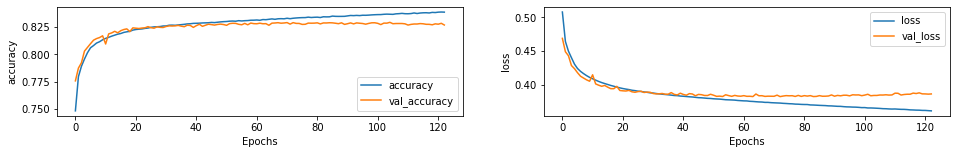

In [11]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

4038/4038 [==============================] - 53s 13ms/step - loss: 0.3879 - accuracy: 0.8265
Test Loss: 0.38792553544044495
Test Accuracy: 0.8264527320861816


              precision    recall  f1-score   support

           0       0.87      0.76      0.82     64602
           1       0.79      0.89      0.84     64602

    accuracy                           0.83    129204
   macro avg       0.83      0.83      0.83    129204
weighted avg       0.83      0.83      0.83    129204

rf auc : 0.9102559850838287


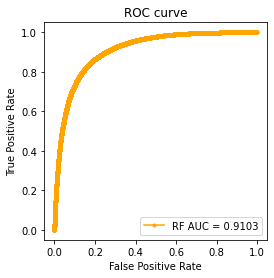

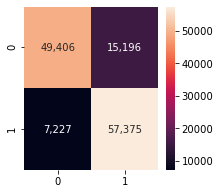

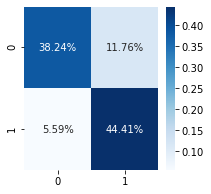

In [14]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()